In [303]:
%matplotlib inline
import os
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import linear_model

import file_handling as fh

sbn.set(font_scale=1.5)


In [304]:
data_dir = '/Users/dcard/Projects/CMU/ARK/LN_tools/parsed/StanfordMSA/'
spreadsheet_file = '/Users/dcard/Dropbox/CMU/ARK/terrorism/databases/MSA/Data/Stanford_MSA_Database.csv'
output_dir = './data/msa/'

msa_df = pd.read_csv(spreadsheet_file, header=0)


In [461]:
msa_descriptions = []
df = pd.DataFrame(columns=['caseid', 'title', 'date', 'year', 'civilian_fatalities', 'enforcement_fatalities', 'n_fatalities', 'n_victims', 'n_articles', 'lat', 'long', 'race'])
articles = []
to_save = []

for index in msa_df.index:
    row = msa_df.loc[index]
    caseid = int(row['CaseID'])
    title = row['Title']
    city = row['City']
    state = row['State']
    lat = row['Latitude']
    long = row['Longitude']
    civilian_fatalities = row['Number of Civilian Fatalities']
    civilian_injuries = row['Number of Civilian Injured']
    enforcement_fatalities = row['Number of Enforcement Fatalities']
    enforcement_injuries = row['Number of Enforcement Injured']
    n_fatalities = int(row['Total Number of Fatalities'])
    n_victims = int(row['Total Number of Victims'])
    description = row['Description']
    date = pd.to_datetime(row['Date'])
    year = date.year
    name = row['Shooter Name']
    num_shooters = row['Number of shooters']
    shooter_age = row['Average Shooter Age']
    sex = row['Shooter Sex']
    race = row['Shooter Race']
    n_shotguns = row['Number of Shotguns']
    n_rifles = row['Number of Rifles']
    n_handguns = row['Number of Handguns']
    n_guns = row['Total Number of Guns']
    n_automatic = row['Number of Automatic Guns']
    n_semi = row['Number of Semi-Automatic Guns']
    fate_at_scene = row['Fate of Shooter at the scene']
    fate_of_shooter = row['Fate of Shooter']
    cause_of_death = row["Shooter's Cause of Death"]
    school_related = row['School Related']
    place_type = row['Place Type']
    relationship_to_place = row['Relationship to Incident Location']
    target_details = row['Targeted Victim/s - Detailed']
    target_general = row['Targeted Victim/s - General']
    motive_details = row['Possible Motive - Detailed']
    motive_general = row['Possible Motive - General']
    mental_details = row['History of Mental Illness - Detailed']
    mental_general = row['History of Mental Illness - General']
    military = row['Military Experience']
    event_type = row['Class']   # MS = mass shooting, SPK = spree killing, SEK = serial, GD = gang/drug, FMS = family murder/suicide
    depreciation = row['Depreciation']  # 0 = does not fit criteria; 2 = borderline

    msa_descriptions.append({'id': caseid, 'text': description})

    input_dir = os.path.join(data_dir, str(caseid) + '_' + '_'.join(name.split()))
    if os.path.exists(input_dir):        
        n_articles = len(glob.glob(os.path.join(input_dir, 'partition', '1', '1', '*.txt')))
        df.loc[index] = [caseid, title, date, year, civilian_fatalities, enforcement_fatalities, n_fatalities, n_victims, n_articles, lat, long, race]
        metadata = fh.read_json(os.path.join(input_dir, 'metadata', 'metadata.json'))
        for article_name in metadata:
            fulldate = metadata[article_name]['fulldate']
            source = metadata[article_name]['source']
            filename = os.path.join(input_dir, 'partition', '1', '1', article_name + '_short.txt')
            if os.path.exists(filename):
                with open(filename, 'r') as f:
                    text = f.read()
                text = '\n'.join(text.split('\n\n')[2:])
                articles.append({'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'eventdate': date, 'race': race})
                to_save.append({'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'race': race})

df['n_articles'] = pd.to_numeric(df['n_articles'])
df['n_victims'] = pd.to_numeric(df['n_victims'])
df['n_fatalities'] = pd.to_numeric(df['n_fatalities'])

print(df.isnull().values.any())

print(len(articles))
fh.write_jsonlist(to_save, os.path.join(output_dir, 'articles.jsonlist'))

False
5857


In [462]:
df['n_incidents'] = 1
grouped = df.groupby('year')
summed = grouped.aggregate(np.sum)
summed.head()


,n_fatalities,n_victims,n_articles,lat,long,n_incidents
year,,,,,,
1990,12,17,23,30.332161,-81.675770,1
1991,47,70,52,189.797143,-458.622110,5
1992,11,30,39,158.838696,-373.664933,4
1993,29,75,128,357.377798,-883.767755,9
1994,12,42,61,170.501175,-354.924583,4


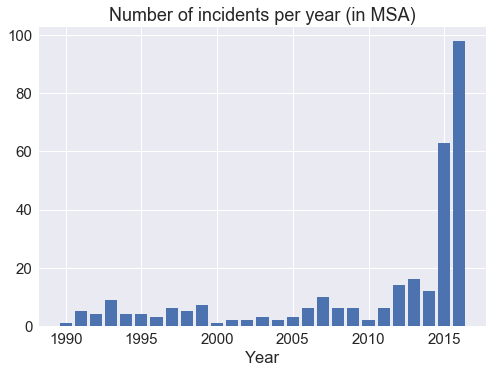

In [339]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Number of incidents per year (in MSA)');


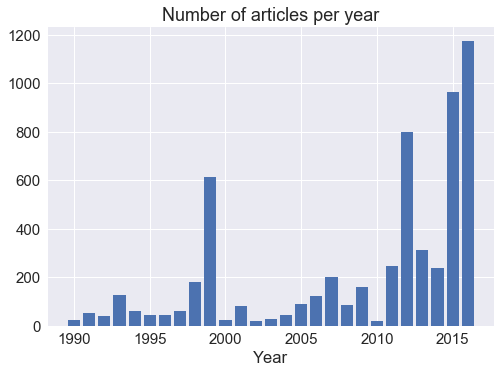

In [340]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles)
ax.set_xlabel('Year')
ax.set_title('Number of articles per year');

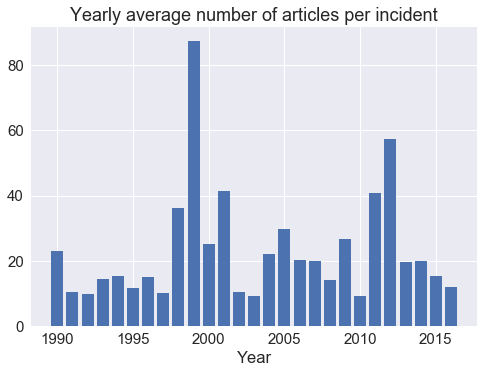

In [341]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of articles per incident');


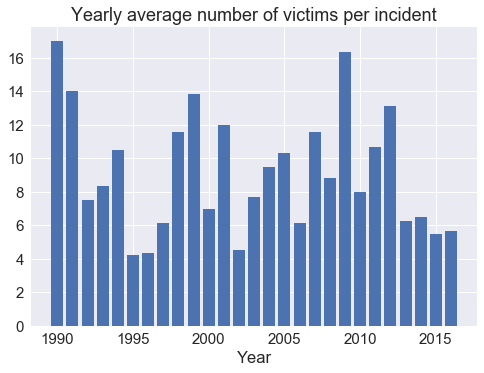

In [389]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_victims / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of victims per incident');


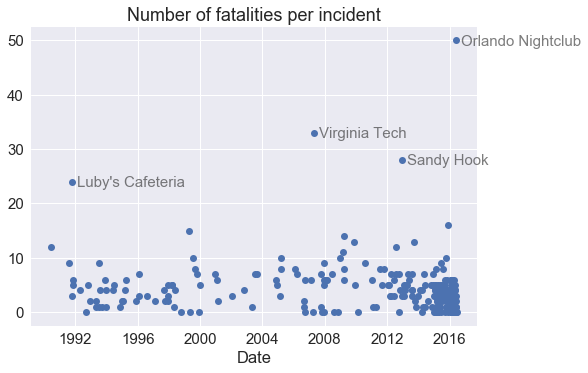

In [343]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_fatalities)
subset = df[df.n_fatalities > 20]
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:2]), xy=(row.date, row.n_fatalities), size=15, xytext=(5, -5), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_title('Number of fatalities per incident');


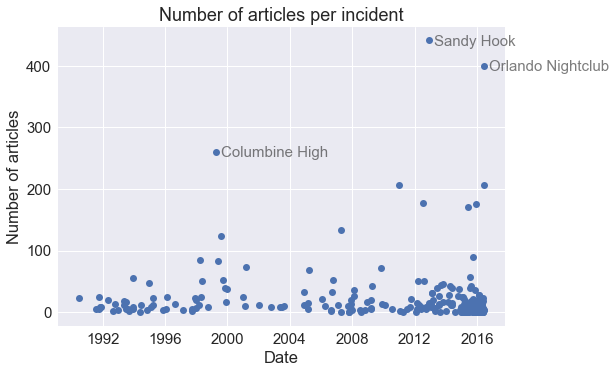

In [344]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_articles)
subset = df[df.n_articles > 250]
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:2]), xy=(row.date, row.n_articles), size=15, xytext=(5, -5), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
ax.set_title('Number of articles per incident')


In [345]:
df.sort_values('n_articles', ascending=False).head(n=10)


,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,n_incidents
137,138,Sandy Hook Elementary School,2012-12-14,2012,27,0,28,29,441,41.411908,-73.311963,1
333,343,Orlando Nightclub Massacre,2016-06-12,2016,49,0,50,102,400,28.538335,-81.379236,1
70,71,Columbine High School,1999-04-20,1999,13,0,15,37,260,39.593583,-105.015211,1
119,120,"Tucson, Arizona",2011-01-08,2011,6,0,6,19,207,32.153589,-110.967765,1
331,341,Cape Coral Shooting Spree,2016-06-07,2016,2,0,3,5,206,26.562854,-81.949533,1
131,132,Movie Theater in Aurora,2012-07-20,2012,12,0,12,70,177,39.729419,-104.982521,1
235,245,"San Bernardino, California",2015-12-02,2015,14,0,16,35,175,34.139734,-117.294244,1
207,215,Mother Emanuel AME Church,2015-06-17,2015,9,0,9,9,171,32.812973,-79.966940,1
97,98,Virginia Tech Campus,2007-04-16,2007,32,0,33,49,134,37.229955,-80.427687,1
72,73,Offices of All-Tech Investment Group and Momen...,1999-07-29,1999,9,0,10,21,123,33.762997,-84.423133,1


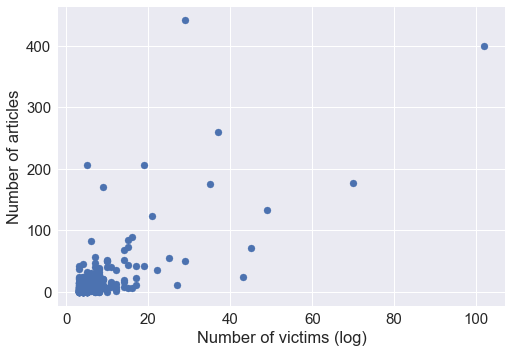

In [346]:
fig, ax = plt.subplots(1, 1)
ax.scatter(np.array(df.n_victims.values, dtype='float'), np.array(df.n_articles.values, dtype='float'))
ax.set_xlabel('Number of victims (log)')
ax.set_ylabel('Number of articles');


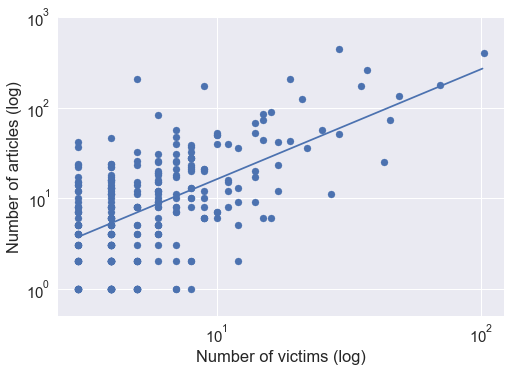

In [347]:
fig, ax = plt.subplots(1, 1)
df_sub = df[df.n_articles > 0]
x = np.array(df_sub.n_victims.values, dtype='float')
y = np.array(df_sub.n_articles.values, dtype='float')
ax.scatter(x, y)
ax.set_xlabel('Number of victims (log)')
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_ylabel('Number of articles (log)');
ax.set_ylim(0.5, 1000)

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(np.log(x).reshape(-1, 1), np.log(y))
x_pred = np.log(np.arange(np.min(x), np.max(x)).reshape(-1, 1))
pred = model.predict(x_pred)
ax.plot(np.exp(x_pred), np.exp(pred))

In [380]:
sources = set([article['source'] for article in articles])
print(sources)

{'washington post', 'palm beach post', 'new york times', 'saint paul pioneer press', 'st. petersburg times', 'san jose mercury news', 'st. louis post-dispatch', 'tampa bay times', 'atlanta journal and constitution', 'daily news', 'usa today', 'philadelphia inquirer'}


In [433]:
event_dates = dict()
articles_per_source = defaultdict(int)
terrorism_mentions_per_source = defaultdict(int)
articles_per_year = defaultdict(int)
terrorism_mentions_per_year = defaultdict(int)
articles_per_event = defaultdict(int)
terrorism_mentions_per_event = defaultdict(int)
articles_per_race = defaultdict(int)
terrorism_mentions_per_race = defaultdict(int)
for article in articles:
    caseid = article['caseid']
    source = article['source']
    event_date = article['eventdate']
    race = article['race']
    year = int(str(article['fulldate'])[:4])
    text = article['text'].lower()    
    event_dates[caseid] = event_date
    articles_per_source[source] += 1
    articles_per_event[caseid] += 1
    articles_per_year[year] += 1
    articles_per_race[race] += 1
    if 'terrorism' in text or 'terrorist' in text:
        terrorism_mentions_per_source[source] += 1
        terrorism_mentions_per_event[caseid] += 1
        terrorism_mentions_per_year[year] += 1
        terrorism_mentions_per_race[race] += 1
event_titles = dict(zip(df.caseid.values, df.title.values))


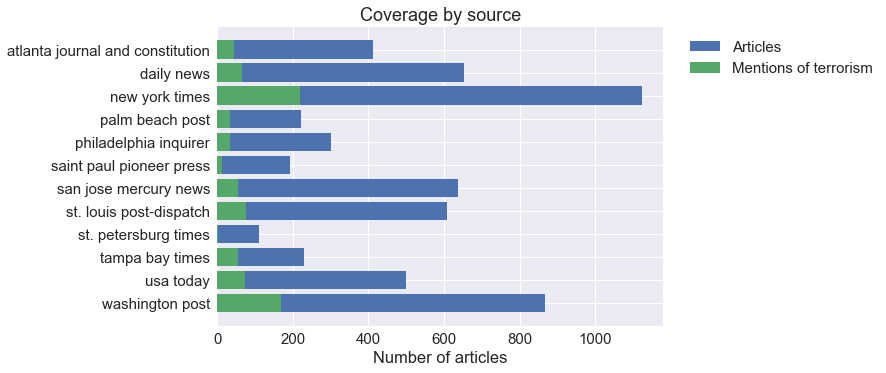

In [434]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_source[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by source')

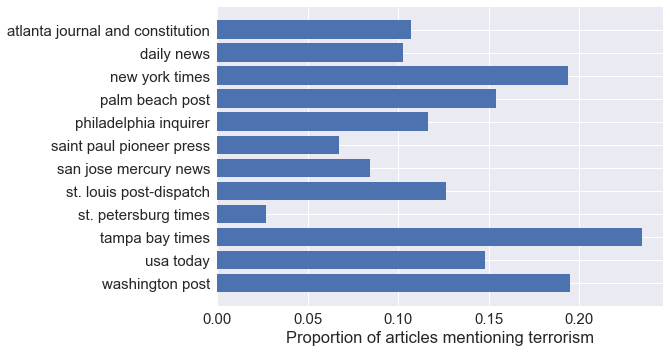

In [435]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k]/articles_per_source[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.set_xlabel('Proportion of articles mentioning terrorism')

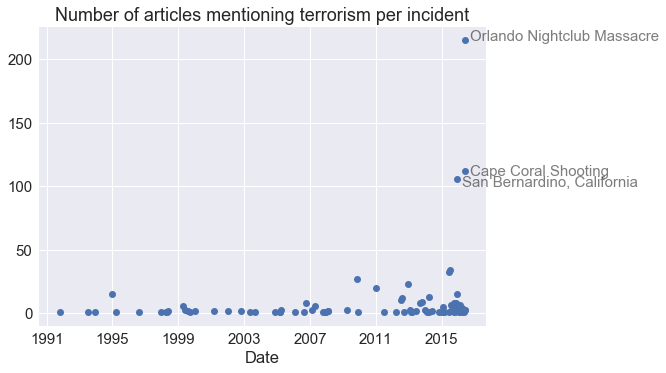

In [436]:
fig, ax = plt.subplots()
#ax.plot_date(list(articles_per_event.keys()), list(articles_per_event.values()))
keys = list(terrorism_mentions_per_event.keys())
dates = [event_dates[caseid] for caseid in keys]
mentions = [terrorism_mentions_per_event[caseid] for caseid in keys]
ax.plot_date(dates, mentions)
count = 0
for caseid in keys:
    if terrorism_mentions_per_event[caseid] > 100:
        count += 1        
        ax.annotate(' '.join(event_titles[caseid].split()[:3]), xy=(event_dates[caseid], terrorism_mentions_per_event[caseid]), size=15, xytext=(5, -12 +4*count), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_title('Number of articles mentioning terrorism per incident')

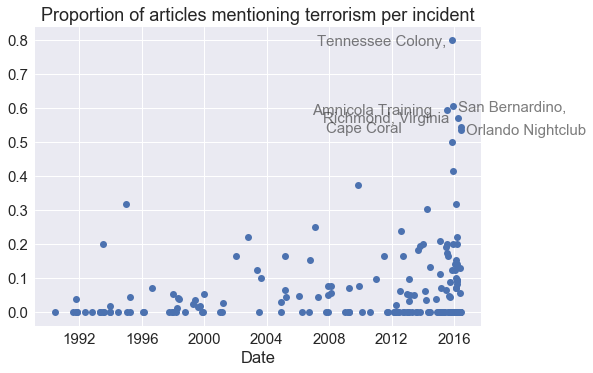

In [458]:
keys = [key for key in articles_per_event.keys() if articles_per_event[key] > 4]
dates = [event_dates[caseid] for caseid in keys]
proportion = [terrorism_mentions_per_event[caseid] / articles_per_event[caseid] for caseid in keys]
fig, ax = plt.subplots()
count = 0
ax.plot_date(dates, proportion)
for caseid in keys:
    proportion = terrorism_mentions_per_event[caseid] / articles_per_event[caseid]
    if proportion > 0.5:
        count += 1        
        ax.annotate(' '.join(event_titles[caseid].split()[:2]), xy=(event_dates[caseid], proportion), size=15, xytext=(5 -140*((count%3)>0), -5), textcoords='offset points', alpha=0.6)

ax.set_xlabel('Date')
ax.set_title('Proportion of articles mentioning terrorism per incident')

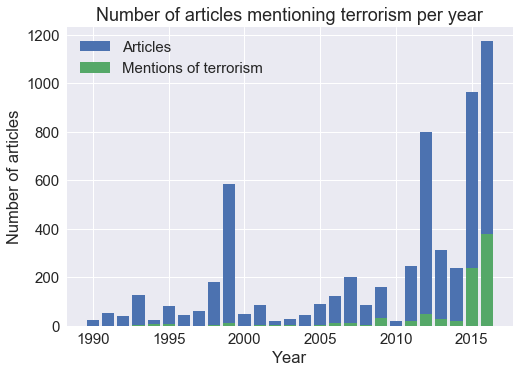

In [480]:
keys = list(articles_per_year.keys())
keys.sort()
fig, ax = plt.subplots()
ax.bar(keys, [articles_per_year[k] for k in keys], label='Articles')
ax.bar(keys, [terrorism_mentions_per_year[k] for k in keys], label='Mentions of terrorism')
ax.set_xlabel('Year')
ax.set_ylabel('Number of articles')
ax.legend()
ax.set_title('Number of articles mentioning terrorism per year')

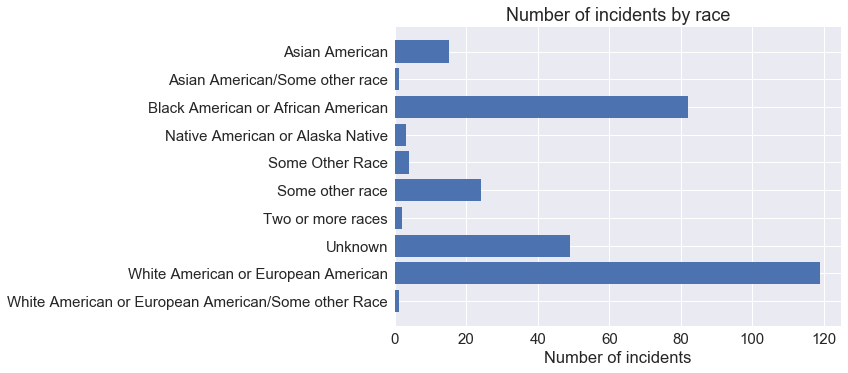

In [478]:
grouped = df.groupby('race')
summed_by_race = grouped.aggregate(np.sum)
summed_by_race.sort_index()
races = list(summed_by_race.index)
fig, ax = plt.subplots()
yticks = list(range(len(races)))
yticks.reverse()
ax.barh(yticks, width=summed_by_race.n_incidents)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of incidents')
ax.set_title('Number of incidents by race');


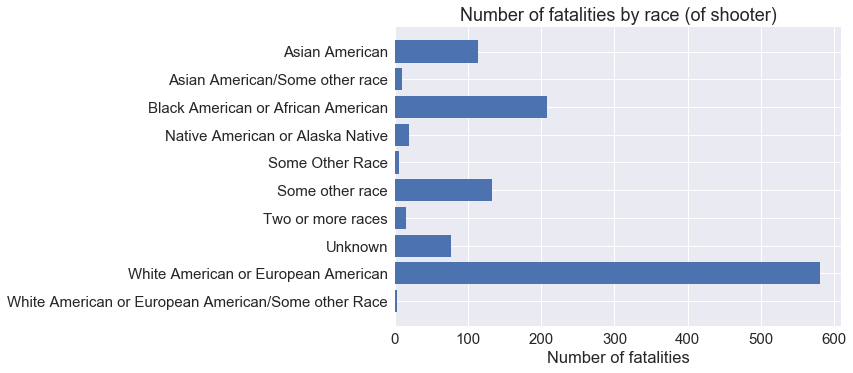

In [487]:
fig, ax = plt.subplots()
ax.barh(yticks, width=summed_by_race.n_fatalities)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of fatalities')
ax.set_title('Number of fatalities by race (of shooter)');

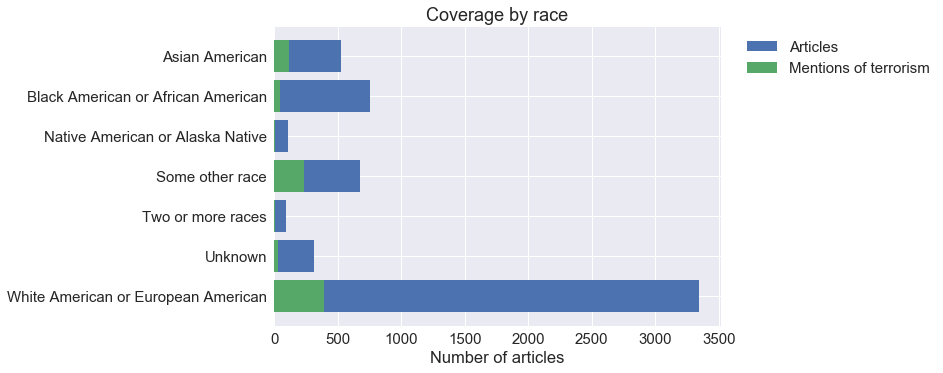

In [484]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_race[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by race');

/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


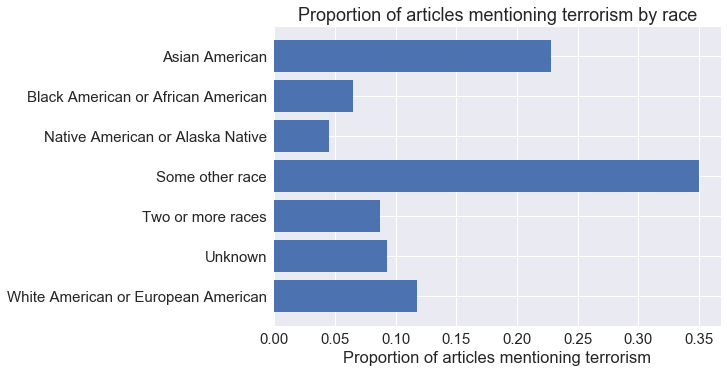

In [489]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] / articles_per_race[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Proportion of articles mentioning terrorism')
ax.set_title('Proportion of articles mentioning terrorism by race');

/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


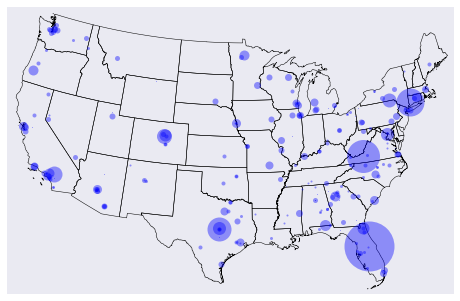

In [357]:
# Can I make a map in matplotlib? Yes!
from mpl_toolkits.basemap import Basemap
import math

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

scale = 1.0
for i in df.index:
    row = df.loc[i]  
    x, y = map(row.long, row.lat)
    map.plot(x, y, marker='o', color='Blue', markersize=(row['n_fatalities'])*scale, alpha=0.4)
    #map.plot(x, y, marker='o', color='Red', markersize=(row['n_articles'])*scale/10., alpha=0.7)
plt.show();

In [384]:
counts = []
for article in articles:
    source = article['source']
    event_date = article['eventdate']
    race = article['race']
    year = int(str(article['fulldate'])[:4])
    text = article['text'].lower()    
    terrorism = 0
    if 'terrorism' in text or 'terrorist' in text:
        terrorism = 1
    islam = 0
    if 'islam' in text or 'muslim' in text:
        islam = 1
    mental = 0
    if 'mental' in text:
        mental = 1
    counts.append([terrorism, islam, mental])
n = len(counts)
counts = np.vstack(counts)
sums = counts.sum(axis=0)
df_counts = pd.DataFrame(counts, columns=['terrorism', 'islam', 'mental'])
print(df_counts.mean())
print(df_counts[df_counts.terrorism == 1].mean())
print(df_counts[df_counts.islam == 1].mean())
print(df_counts[df_counts.mental == 1].mean())



terrorism    0.143760
islam        0.107393
mental       0.171248
dtype: float64
terrorism    1.000000
islam        0.511876
mental       0.260095
dtype: float64
terrorism    0.685215
islam        1.000000
mental       0.248013
dtype: float64
terrorism    0.218345
islam        0.155533
mental       1.000000
dtype: float64


In [385]:
n_sources = len(set(sources))
years = range(df.year.min(), df.year.max()+1)
articles_per_year_by_source = {source: {year: 0 for year in years} for source in sources}
for article in articles:
    source = article['source']
    year = int(str(article['fulldate'])[:4])
    articles_per_year_by_source[source][year] += 1


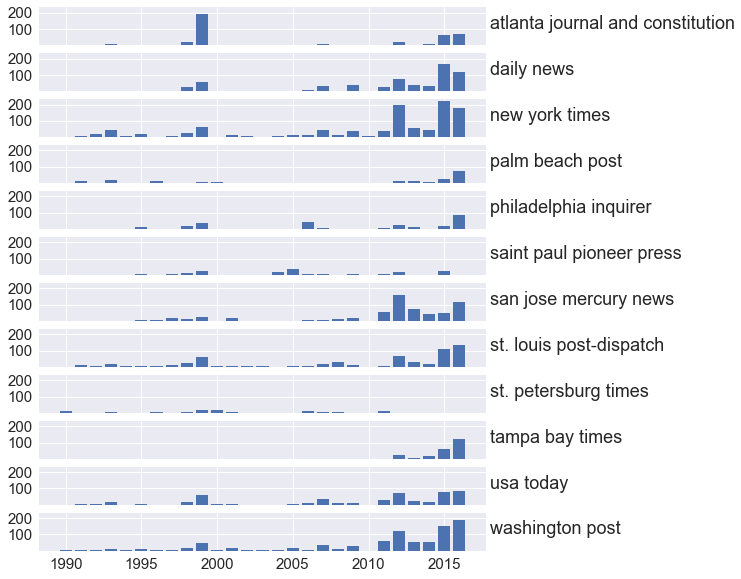

In [386]:
fig, axes = plt.subplots(n_sources, 1, figsize=(8, 10), sharex=True, sharey=True)
sources = list(sources)
sources.sort()
for i, source in enumerate(sources):
    years = list(articles_per_year_by_source[source].keys())
    counts = [articles_per_year_by_source[source][year] for year in years]
    axes[i].bar(years, counts)
    axes[i].text(2018, 100, source)
    axes[i].set_yticks([100, 200])
    
